# Benchmark test of classification models
This code is taken from <https://scikit-learn.org/stable/auto_examples/text/plot_document_classification_20newsgroups.html> and we used it to get a quick overview of several text classification models early in the project

In [ ]:
import logging
import numpy as np
from optparse import OptionParser
import sys
from time import time
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import RidgeClassifier
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import Perceptron
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.naive_bayes import BernoulliNB, ComplementNB, MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import NearestCentroid
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils.extmath import density
from sklearn import metrics

import pandas as pd

# the actual classification algorithm
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.linear_model import SGDClassifier
# for converting training and test datasets into matrices
# TfidfVectorizer does this specifically for documents
from sklearn.feature_extraction.text import TfidfVectorizer

# for bundling the vectorizer and the classifier as a single "package"
from sklearn.pipeline import make_pipeline

# for splitting the dataset into training and test sets
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

# for evaluating the quality of the classifier
from sklearn.metrics import accuracy_score

# FUNCT 1: Alla håller med
def all_agrees(val):
    parts = [int(x) for x in val.split("/")]
    
    if parts.count(0) == len(parts):
        return 0
    elif parts.count(1) == len(parts):
        return 1
    else:
        return -1
        
# FUNC 2: Alla utom -1 håller med
def all_but_minus(val):
    parts = [int(x) for x in val.split("/")]
    cnt0 = parts.count(0)
    cnt1 = parts.count(1)

    if cnt0 > 0 and cnt1 == 0: 
        return 0
    elif cnt1 > 0 and cnt0 == 0:
        return 1
    else:
        return -1

# FUNCT 3: De flesta håller med
def most_agrees(val):
    parts = [int(x) for x in val.split("/")]    
    if parts.count(0) > len(parts) / 2: 
        return 0
    elif parts.count(1) > len(parts) / 2:
        return 1
    else:
        return -1

def read_data(path, scoring):
    data = pd.read_csv(path, sep="\t", header=0)
    data.columns = ['score', 'text']    
    data['score'] = data.score.apply(scoring)
    data = data[data.score != -1]
    return data

data = read_data("a3_train_final.tsv", most_agrees)
test = read_data("a3_test_final.tsv", lambda x: x)

X_train, Y_train = data['text'], data['score']
X_test, Y_test = test['text'], test['score']

vectorizer = TfidfVectorizer()
X_train = vectorizer.fit_transform(X_train)
X_test = vectorizer.transform(X_test)


def benchmark(clf):
    print('_' * 80)
    print("Training: ")
    print(clf)
    t0 = time()
    clf.fit(X_train, Y_train)
    train_time = time() - t0
    print("train time: %0.3fs" % train_time)

    t0 = time()
    pred = clf.predict(X_test)
    test_time = time() - t0
    print("test time:  %0.3fs" % test_time)

    score = metrics.accuracy_score(Y_test, pred)
    print("accuracy:   %0.3f" % score)

    print()
    clf_descr = str(clf).split('(')[0]
    return clf_descr, score, train_time, test_time


results = []
for clf, name in (
        (RidgeClassifier(tol=1e-2, solver="sag"), "Ridge Classifier"),
        (Perceptron(max_iter=50), "Perceptron"),
        (PassiveAggressiveClassifier(max_iter=50),
         "Passive-Aggressive"),
        (KNeighborsClassifier(n_neighbors=10), "kNN"),
        (RandomForestClassifier(), "Random forest")):
    print('=' * 80)
    print(name)
    results.append(benchmark(clf))

for penalty in ["l2", "l1"]:
    print('=' * 80)
    print("%s penalty" % penalty.upper())
    # Train Liblinear model
    results.append(benchmark(LinearSVC(penalty=penalty, dual=False,
                                       tol=1e-3)))

    # Train SGD model
    results.append(benchmark(SGDClassifier(alpha=.0001, max_iter=50,
                                           penalty=penalty)))


# Train SGD with Elastic Net penalty
print('=' * 80)
print("Elastic-Net penalty")
results.append(benchmark(SGDClassifier(alpha=.0001, max_iter=50,
                                       penalty="elasticnet")))

# Train NearestCentroid without threshold
print('=' * 80)
print("NearestCentroid (aka Rocchio classifier)")
results.append(benchmark(NearestCentroid()))

# Train sparse Naive Bayes classifiers
print('=' * 80)
print("Naive Bayes")
results.append(benchmark(MultinomialNB(alpha=.01)))
results.append(benchmark(BernoulliNB(alpha=.01)))
results.append(benchmark(ComplementNB(alpha=.1)))

print('=' * 80)
print("LinearSVC with L1-based feature selection")
# The smaller C, the stronger the regularization.
# The more regularization, the more sparsity.
results.append(benchmark(Pipeline([
  ('feature_selection', SelectFromModel(LinearSVC(penalty="l1", dual=False,
                                                  tol=1e-3))),
  ('classification', LinearSVC(penalty="l2"))])))

Ridge Classifier
________________________________________________________________________________
Training: 
RidgeClassifier(solver='sag', tol=0.01)
train time: 0.115s
test time:  0.000s
accuracy:   0.879

Perceptron
________________________________________________________________________________
Training: 
Perceptron(max_iter=50)
/shared-libs/python3.7/py/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:556: UserWarning: "sag" solver requires many iterations to fit an intercept with sparse inputs. Either set the solver to "auto" or "sparse_cg", or set a low "tol" and a high "max_iter" (especially if inputs are not standardized).
  '"sag" solver requires many iterations to fit '
train time: 0.084s
test time:  0.001s
accuracy:   0.850

Passive-Aggressive
________________________________________________________________________________
Training: 
PassiveAggressiveClassifier(max_iter=50)
/shared-libs/python3.7/py/lib/python3.7/site-packages/sklearn/linear_model/_stochastic_gradie

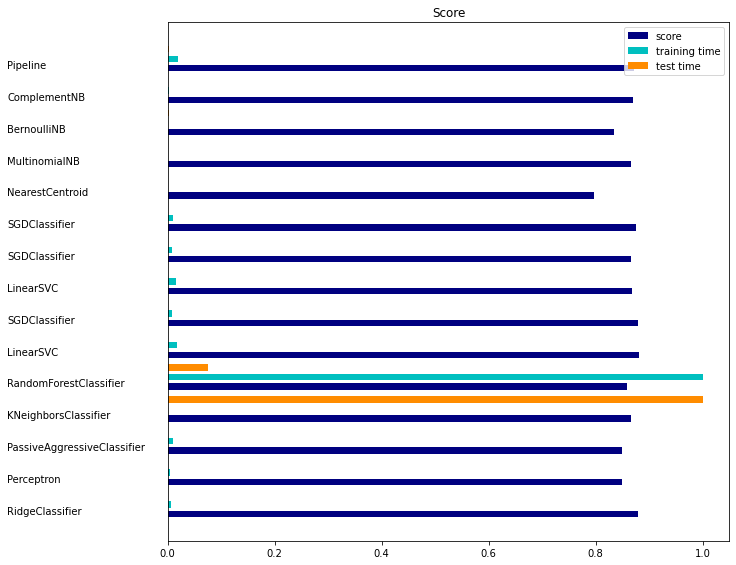

RidgeClassifier               0.878547
Perceptron                    0.850170
PassiveAggressiveClassifier   0.850170
KNeighborsClassifier          0.866061
RandomForestClassifier        0.858116
LinearSVC                     0.880817
SGDClassifier                 0.878547
LinearSVC                     0.868331
SGDClassifier                 0.867196
SGDClassifier                 0.876277
NearestCentroid               0.796822
MultinomialNB                 0.866061
BernoulliNB                   0.835414
ComplementNB                  0.870602
Pipeline                      0.871737


In [ ]:
indices = np.arange(len(results))

results = [[x[i] for x in results] for i in range(4)]

clf_names, score, training_time, test_time = results
training_time = np.array(training_time) / np.max(training_time)
test_time = np.array(test_time) / np.max(test_time)

plt.figure(figsize=(12, 8))
plt.title("Score")
plt.barh(indices, score, .2, label="score", color='navy')
plt.barh(indices + .3, training_time, .2, label="training time",
         color='c')
plt.barh(indices + .6, test_time, .2, label="test time", color='darkorange')
plt.yticks(())
plt.legend(loc='best')
plt.subplots_adjust(left=.25)
plt.subplots_adjust(top=.95)
plt.subplots_adjust(bottom=.05)

for i, c in zip(indices, clf_names):
    plt.text(-.3, i, c)

plt.show()

for name, scores in zip(clf_names, score):
    print('{0: <30}'.format(name) + "{:.6f}".format(scores))    

